## XGBoost

### 1. Objective

* Create a spam filter that is good from the cybersecurity perspective
* As the result *False Negatives* have much bigger effect than *False Positives*

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, KFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

### 2. Dataset

* 5,693 labelled emails
* Unbalanced dataset (positive class is minority – 1/3)
* Raw text – feature extraction required

In [31]:
# Import dataset, conduct some EDA and pre-process

train_data = pd.read_csv("D:\ML\Datasets\emails.csv")
train_data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [32]:
train_data.describe(include=[object])

,text
count,5726
unique,5693
top,Subject: * special notification * aurora versi...
freq,2


In [33]:
# Remove duplicate values

train_data = train_data.drop_duplicates(subset='text')
train_data.describe(include=[object])

,text
count,5693
unique,5693
top,Subject: energy derivative courses dear vince...
freq,1


In [34]:
# Separate labels

y = train_data['spam']
train_data.drop(labels='spam', axis=1, inplace=True)

### 3. Feature selection

* CountVectorizer bag of words was used to create a sparse matrix
* Each datapoint (email) ended up having the same feature vector length as the result which is good for tree-based algorithms
* Word ‘Subject’ was removed, punctuation was removed, accented characters were kept 
* 37k features
* Top 500 features selected based on occurrence frequency

In [35]:
# Create bag of words

vectorizer = CountVectorizer(stop_words=['subject'], max_features=500) 
                             #, strip_accents="unicode")
X = vectorizer.fit_transform(train_data.text)
features = vectorizer.get_feature_names() # to check feature names if required
X = X.toarray()
X.shape

(5693, 500)

### 4. Algorithm selection, training and evaluation (using k-fold cross validation)

***Why XGBoost?***

* Weighted loss function (easy to assign more weight to positive class)
* Feature scaling not required for tree-based algorithms
* Collinearity is not an issue
* Good for sparse datasets
* L1 regularisation can be easily implemented as boosted algorithms are sensitive to outliers (i.e. prediction is far from actual class)
* Fast (but slower than LightGBM)

In [36]:
# Specify model and KFold parameters

model = XGBClassifier(n_estimators=50, scale_pos_weight=3, max_depth=8, learning_rate=0.3, verbosity=0, random_state=1
                      , reg_alpha=5, reg_lambda=0, use_label_encoder=False)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [45]:
# Make predictions

predictions = cross_val_predict(model, X, y, cv=cv)

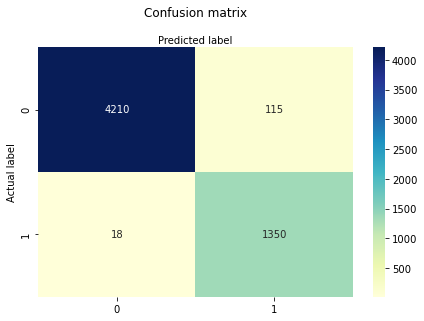

In [38]:
# Print confusion matrix

cm = confusion_matrix(y, predictions)
class_names = [0, 1] # names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu",fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
# Print classification report

print("Classification Report:")
print(classification_report(y, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4325
           1       0.92      0.99      0.95      1368

    accuracy                           0.98      5693
   macro avg       0.96      0.98      0.97      5693
weighted avg       0.98      0.98      0.98      5693



In [40]:
scores = cross_validate(model, X, y, cv=cv, scoring=('accuracy', 'precision', 'recall', 'roc_auc'), return_train_score=True)
#print(scores.keys()) # to obtain dict keys

In [41]:
mean_train_acc = round(np.mean((scores['train_accuracy'])), 2)
mean_test_acc = round(np.mean((scores['test_accuracy'])), 2)
mean_train_prec = round(np.mean((scores['train_precision'])), 2)
mean_test_prec = round(np.mean((scores['test_precision'])), 2)
mean_train_rec = round(np.mean((scores['train_recall'])), 2)
mean_test_rec = round(np.mean((scores['test_recall'])), 2)
mean_train_roc_auc = round(np.mean((scores['train_roc_auc']), dtype=np.float64), 2)
mean_test_roc_auc = round(np.mean((scores['test_roc_auc']), dtype=np.float64), 2)
print("Mean accuracy score (training): {0:.2f}".format(mean_train_acc))
print("Mean accuracy score (testing): {0:.2f}".format(mean_test_acc))
print("Mean precision score (training): {0:.2f}".format(mean_train_prec))
print("Mean precision score (testing): {0:.2f}".format(mean_test_prec))
print("Mean recall score (training): {0:.2f}".format(mean_train_rec))
print("Mean recall score (testing): {0:.2f}".format(mean_test_rec))
print("Mean ROC AUC score (training): {0:.2f}".format(mean_train_roc_auc))
print("Mean ROC AUC score (testing): {0:.2f}".format(mean_test_roc_auc))

Mean accuracy score (training): 0.99
Mean accuracy score (testing): 0.98
Mean precision score (training): 0.97
Mean precision score (testing): 0.92
Mean recall score (training): 1.00
Mean recall score (testing): 0.99
Mean ROC AUC score (training): 1.00
Mean ROC AUC score (testing): 1.00


In [42]:
FPR = 123 / (123 + 4237) # FP / FP + TN
FNR = 20 / (20 + 1348) # FN / FN + TP
TNR = 4237 / (4273 + 123) # TN / TN + FP (Specificity)
TPR = 1348 / (1348 + 20)
print("False Positive Rate (testing): {0:.2f}".format(FPR))
print("False Negative Rate (testing): {0:.2f}".format(FNR))
print("Specificity (testing): {0:.2f}".format(TNR))
print("Sensitivity (testing): {0:.2f}".format(TPR))

False Positive Rate (testing): 0.03
False Negative Rate (testing): 0.01
Specificity (testing): 0.96
Sensitivity (testing): 0.99


### 5. Conclusion

* The model is good at catching spam (99% will end up in spam folder)
* but a little too cautious as 3-4% of legitimate emails will also end up in spam folder

### 6. Future improvements

* Feature selection/ reduction can potentially be significantly improved as feature correlation is high judging by feature correlation map (not included in the presentation)
* Hyperparameter tuning can be automated to yield better results (e.g. GridSearchCV)